In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

In [2]:
original_data = pd.read_csv(r'C:\Users\zengziji_dg\Desktop\myblog\kaggle\titanic\train.csv')

In [3]:
data = original_data.copy()

In [4]:
# 整体概况
def birdview(data):
    print("---整体数据概况---")
    print(data.shape)
    b = {}
    d = {}
    for col in data.columns:
        b[col] = len(data[col].unique())
        if len(list(data[col].unique()))<30:
            d[col] = str(data[col].unique())
        else:
            d[col] = "too much"
    r = pd.DataFrame(pd.Series(d),columns=['values'])\
            .join(pd.DataFrame(pd.Series(b),columns=['unique']))\
            .join(pd.DataFrame(data.dtypes,columns=['type']))\
            .join(pd.DataFrame(data.count(),columns=['count']))\
            .join(pd.DataFrame(data.isnull().sum(),columns=['isnull']))\
            .join(pd.DataFrame(pd.Series(b).divide(len(data)),columns=['unique_rate']))
    return r.sort_values(by=['values','type',])

In [5]:
data_desc1 = birdview(original_data)


---整体数据概况---
(891, 12)


In [6]:
#删除无关紧要的字段,
for myindex in data_desc1['unique_rate'].index:
    if data_desc1['unique_rate'][myindex]>0.7:
        print('deleting col:',myindex)
        del data[myindex]

deleting col: PassengerId
deleting col: Name
deleting col: Ticket


In [7]:
data.describe().T
data.isnull().sum()/len(data)
null_data = data.isnull().sum()
null_data[null_data>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [8]:
def knn(row,x,y,k=2,mytype='most'):
    if type(y)!=list:
        y = list(y)
    diff_row_x = np.tile(row,(x.shape[0],1)) - x #tile构建跟x一样行数的重复row的矩阵
    distance = ((diff_row_x**2).sum(axis=1))**0.05#axis=1代表列相加
    sorted_distance = list(distance.argsort())#按从小到大排序的索引值列表
    result = {};k_values=[]
    for i in range(0,k):
        y_like = y[sorted_distance[i]]
        k_values.append(y_like)
        result[y_like] = result.get(y_like,0) + 1#字典计算，默认为0
    if mytype=='avg':
        output = np.mean(k_values)
    elif mytype=='most':
        temp = sorted(result.items(),key = lambda x:x[1],reverse = True)
        output = temp[0][0]
    return output

# 用众数填充缺失值
def myfillna(old_data,ratio=0.4):
    data = old_data.copy()
    all_cols = list(data.columns)
    null_data = data.isnull().sum()
    null_data = null_data[null_data>0]
    for i in list(null_data.index):
        all_cols.remove(i)

    for null_col in null_data.index:
        if data.dtypes[null_col] != np.object:
            if data[null_col].isnull().sum()/len(data)<ratio:
                ##热编码
                x_train = pd.get_dummies(data[data[null_col].notnull()][all_cols])#缺失值列均不参与knn
                y_train = data[data[null_col].notnull()][null_col]
                x_test = pd.get_dummies(data[(data[null_col].isnull())][all_cols])
                for index, row in x_test.iterrows():
                    predict_value = knn(row,x=x_train,y=y_train,k=2,mytype='most')
                    data[null_col][index] = predict_value
            else:
                normal_value = data[null_col].mode()[0]
                data[null_col] = data[null_col].fillna(normal_value)
        else:
            data[null_col] = data[null_col].fillna('PyN')
    return data

data = myfillna(data)

c:\users\zengziji_dg\envs\kaggle\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
import math
import numpy as np
import seaborn as sns
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        # 定性
        if dataset.dtypes[column] == np.object: 
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        # 定值
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)

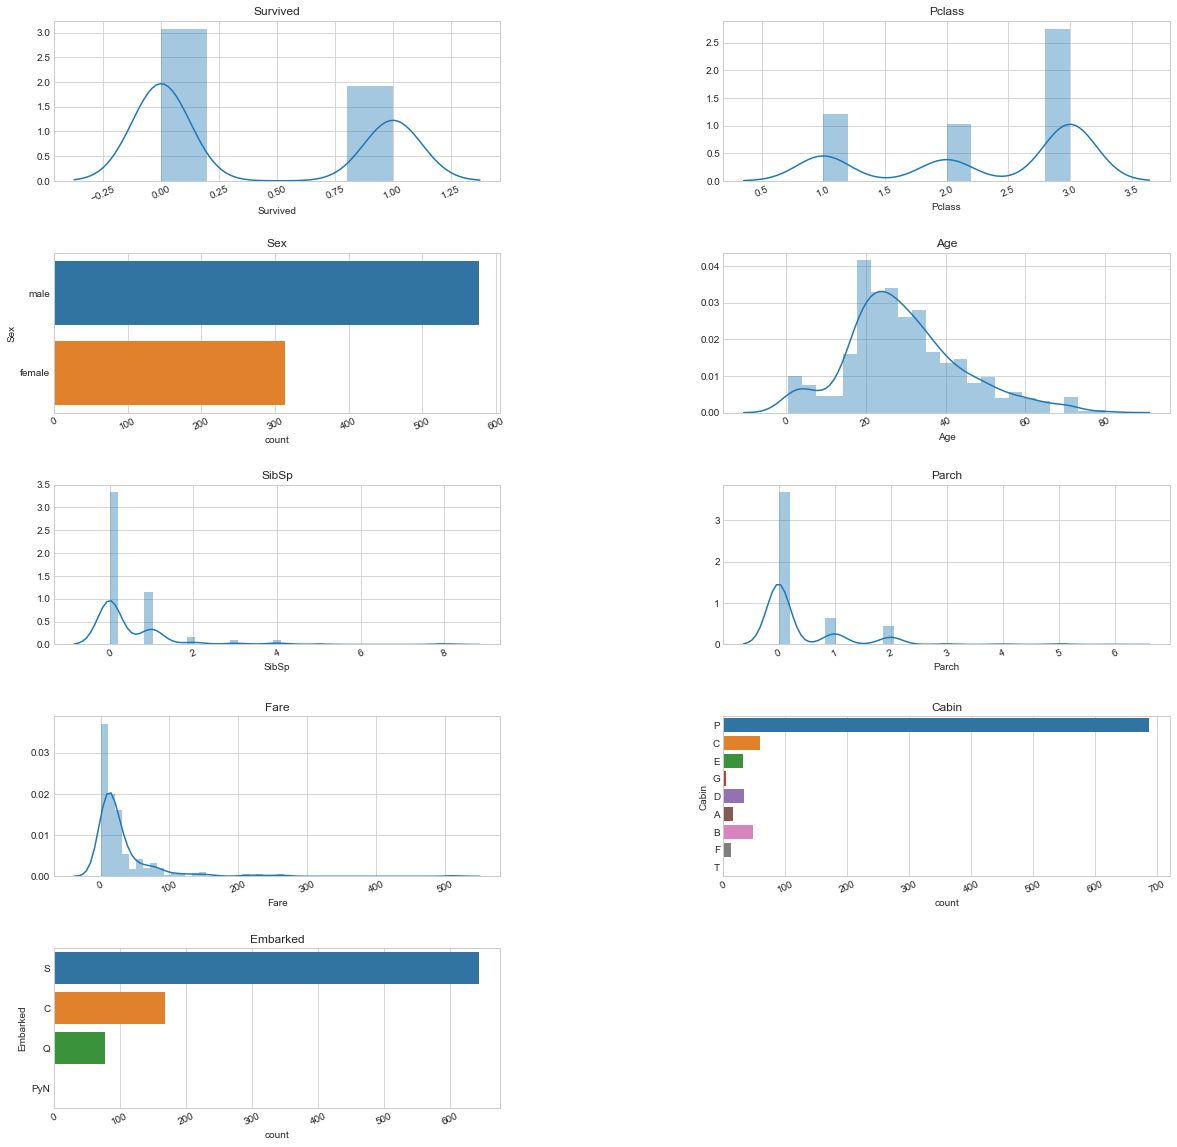

In [10]:
# 从上述统计图可以看出，sex是个重要因子，而cabin过于凌乱，此处处理下该字段
data['Cabin'] = data['Cabin'].str[:1]
plot_distribution(data, cols=2, width=20, height=20, hspace=0.45, wspace=0.5)#col代表每行有多少张图片

In [215]:
#计算熵，值越接近0则说明分类效果越好unique_counts = dict(data[column].value_counts())
def entropy(unique_counts):
    from math import log
    ent = 0.0
    for r in unique_counts.keys():
        p = unique_counts[r]/sum(unique_counts.values())#每个分类的概率p
        ent = ent - p * (log(p)/log(2)) #p=0时，ent=0；p=1时，log2p=0
    return ent

# 1R方法，适用于有监督情况，将连续数值型特征分割成分类型特征
# 思路为：每个间隔至少为n个样本，如果排序后加了上了下一个值对应的样本，分类效果更好了则不分割
def divide_into(x_column,y_column,dataset,interval_max=24,threshold=1.01):
    interval = int(len(data)/interval_max)
    temp_data = dataset[[x_column,y_column]].sort_values(by=x_column)
    old_ent = 1000000
    values_points = temp_data.groupby(x_column).count().index
    begin = temp_data[x_column].min()-0.01#因为切割时左区间是开的，所以要降低下
    cut_point = [begin]
    print('-----------%s-----------'%x_column)
    for pos,value in enumerate(values_points[1:]):
        end = value
        mydata = temp_data[(temp_data[x_column]>begin) & (temp_data[x_column]<=end)]
        num_cout = mydata[x_column].count()
        #要求间隔大于interval参数
        if num_cout>interval:
            unique_counts = dict(mydata[y_column].value_counts())
            new_ent = entropy(unique_counts)
            if new_ent>threshold*old_ent:#若新间隔熵值更大（放大threshold倍是为了找到分割点更好的），说明增加样本效果不好，应切断
                cut_point.append(end)
                print('[%d,%d)'%(begin,end),num_cout)
                begin = value
                old_ent = 1000000 ##切断后重置ole_ent
            else:
                old_ent = new_ent ##记录新区间熵值
    if value not in cut_point:
        cut_point.append(value)
        print('[%d,%d)'%(begin,value),num_cout)
    return cut_point

def num_to_str(data,hue):
    new_data = data.copy()
    for i, column in enumerate(new_data.columns):
        if new_data.dtypes[column]!= np.object:
            ##数值型字段种类要大于12个以上才进行分割
            if new_data[column].value_counts().count()>12:
                # 数值型字段区间分割成分类型
                cut_points = divide_into(column,hue,new_data)
                new_data[column] = pd.cut(data[column],cut_points).astype('object')
            else:
                new_data[column] = data[column].astype('object')
    return new_data

data = num_to_str(data,hue='Survived')

-----------Age-----------
[0,7) 54
[7,22) 234
[22,26) 130
[26,31) 127
[31,35) 86
[35,38) 51
[38,48) 112
[48,80) 97
-----------Fare-----------
[0,7) 43
[7,7) 44
[7,7) 70
[7,7) 84
[7,8) 45
[8,9) 45
[9,12) 43
[12,512) 517


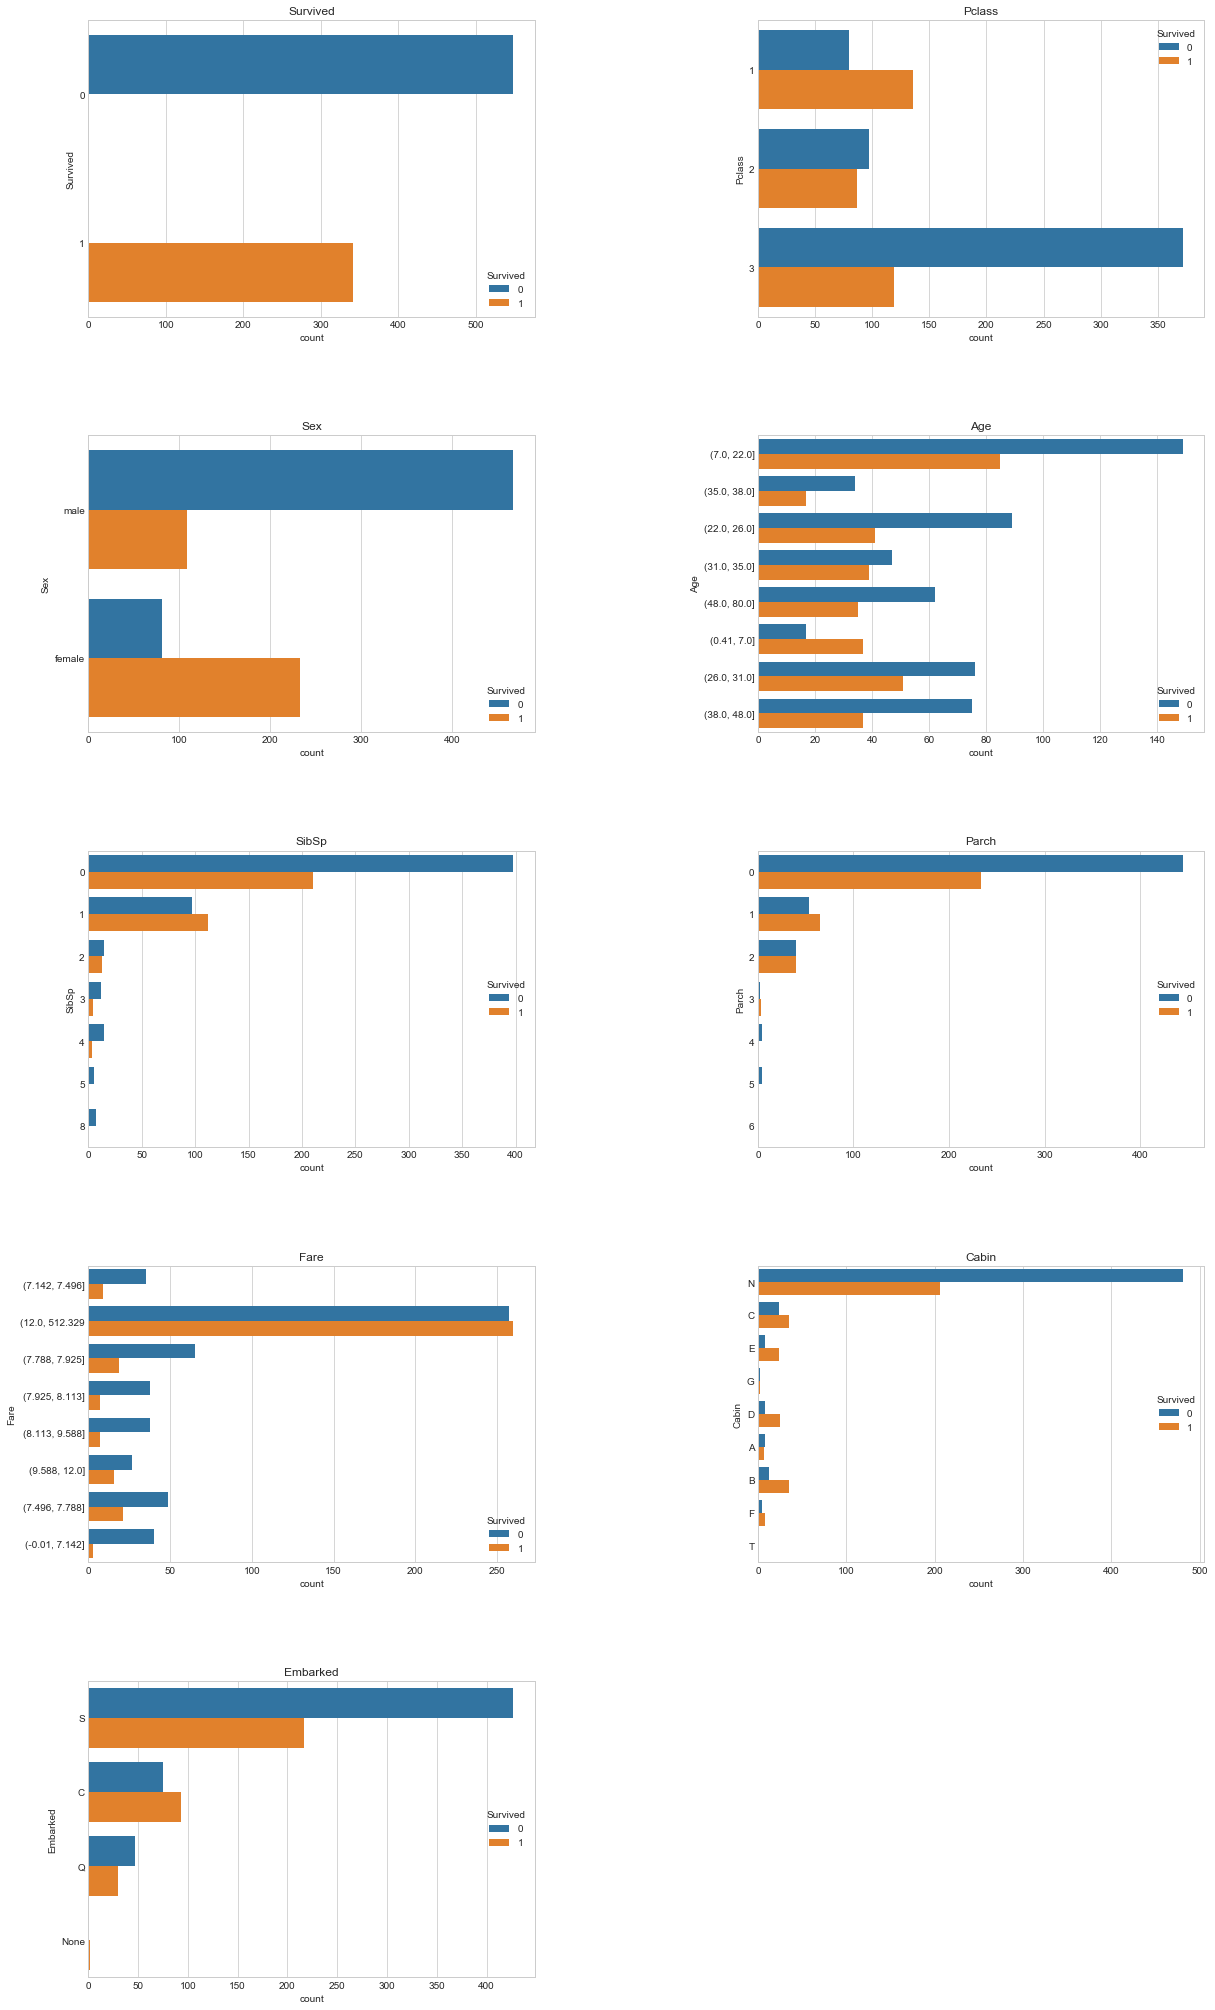

In [216]:
# 在不同类别属性上观察两种标签的分布情况
def plot_bivariate_bar(dataset, hue, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    dataset = dataset.select_dtypes(include=[np.object])
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        g = sns.countplot(y=column, hue=hue, data=dataset)
        substrings = [s.get_text()[:14] for s in g.get_yticklabels()]
        g.set(yticklabels=substrings)

plot_bivariate_bar(data, hue='Survived', cols=2, width=20, height=36, hspace=0.4, wspace=0.5)